In [12]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from scipy.optimize import minimize

In [13]:
portfolio = {
  "portfolio": [

    {"symbol": "NVDA", "totalValue": 1000, "percentageOfPortfolio": 12.5},
    {"symbol": "AMD", "totalValue": 1000, "percentageOfPortfolio": 12.5},
    {"symbol": "META", "totalValue": 1000, "percentageOfPortfolio": 12.5},
    {"symbol": "GOOGL", "totalValue": 1000, "percentageOfPortfolio": 12.5},
    {"symbol": "TSLA", "totalValue": 1000, "percentageOfPortfolio": 12.5},
    {"symbol": "AMZN", "totalValue": 1000, "percentageOfPortfolio": 12.5},
    {"symbol": "MSFT", "totalValue": 1000, "percentageOfPortfolio": 12.5},
    {"symbol": "FSLY", "totalValue": 1000, "percentageOfPortfolio": 12.5}
  ]
}
# Extract symbols into a list
symbols = [entry["symbol"] for entry in portfolio["portfolio"]]

print(symbols)

['NVDA', 'AMD', 'META', 'GOOGL', 'TSLA', 'AMZN', 'MSFT', 'FSLY']


In [14]:
tickers = symbols
end_date = datetime.today()
start_date = end_date - timedelta(days = 5*365)

In [15]:
adj_close_df = pd.DataFrame()
for ticker in tickers:
    data = yf.download(ticker, start = start_date,end = end_date)
    adj_close_df[ticker] = data['Adj Close']

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [16]:
log_returns = np.log(adj_close_df / adj_close_df.shift(1))

In [17]:
cov_matrix = log_returns.cov() * 252
print(cov_matrix)

           NVDA       AMD      META     GOOGL      TSLA      AMZN      MSFT  \
NVDA   0.258997  0.203648  0.124802  0.102895  0.168484  0.109313  0.110873   
AMD    0.203648  0.273918  0.113736  0.094453  0.152459  0.105032  0.099161   
META   0.124802  0.113736  0.200499  0.092781  0.100383  0.096550  0.083693   
GOOGL  0.102895  0.094453  0.092781  0.101643  0.083800  0.073491  0.073475   
TSLA   0.168484  0.152459  0.100383  0.083800  0.418610  0.099211  0.090659   
AMZN   0.109313  0.105032  0.096550  0.073491  0.099211  0.123144  0.072909   
MSFT   0.110873  0.099161  0.083693  0.073475  0.090659  0.072909  0.092024   
FSLY   0.199795  0.180895  0.141445  0.101354  0.209851  0.131787  0.106474   

           FSLY  
NVDA   0.199795  
AMD    0.180895  
META   0.141445  
GOOGL  0.101354  
TSLA   0.209851  
AMZN   0.131787  
MSFT   0.106474  
FSLY   0.762136  


In [18]:
def standard_deviation(weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

def expected_return(weights, log_returns):
    return np.sum(log_returns.mean()*weights)*252

def sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return (expected_return(weights, log_returns) - risk_free_rate) / standard_deviation(weights, cov_matrix)

In [19]:
risk_free_rate = .02

from fredapi import Fred

fred = Fred(api_key='ad1cb1e80ed505ce5d9d3b66e24962d5')
ten_year_treasury_rate = fred.get_series_latest_release('GS10') / 100

risk_free_rate = ten_year_treasury_rate.iloc[-1]
print(risk_free_rate)

0.0406


In [20]:

def neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate)

constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
bounds = [(0, 0.4) for _ in range(len(tickers))]
initial_weights = np.array([1/len(tickers)]*len(tickers))

optimized_results = minimize(neg_sharpe_ratio, initial_weights, args=(log_returns, cov_matrix, risk_free_rate), method='SLSQP', constraints=constraints, bounds=bounds)

In [21]:
optimal_weights = optimized_results.x

print("Optimal Weights:")
for ticker, weight in zip(tickers, optimal_weights):
    if(weight > 1e-6):
        print(f"{ticker}: {weight:.4f}")

optimal_portfolio_return = expected_return(optimal_weights, log_returns)
optimal_portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)

print(f"Expected Annual Return: {optimal_portfolio_return:.4f}")
print(f"Expected Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

Optimal Weights:
NVDA: 0.4000
AMD: 0.0150
TSLA: 0.1850
MSFT: 0.4000
Expected Annual Return: 0.4252
Expected Volatility: 0.3858
Sharpe Ratio: 0.9969


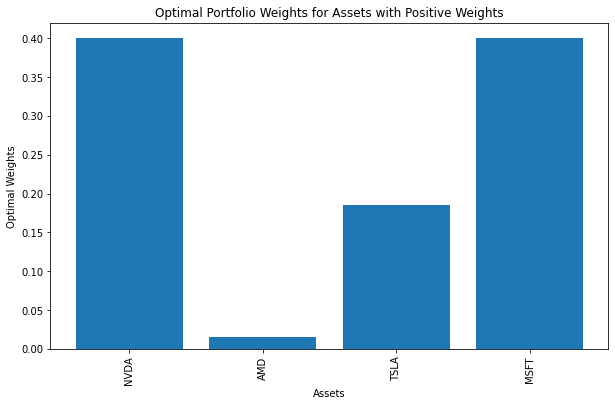

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'tickers' is a list of asset tickers, and 'optimal_weights' is an array of weights.
# We'll filter these to include only those with 'optimal_weights' greater than a small threshold.

# Define a threshold to consider as effectively zero (to handle floating-point precision)
threshold = 1e-6

# Filter tickers and weights where weights are greater than the threshold
filtered_tickers = [ticker for ticker, weight in zip(tickers, optimal_weights) if weight > threshold]
filtered_weights = [weight for weight in optimal_weights if weight > threshold]

# Now, plot the filtered data
plt.figure(figsize=(10, 6))
plt.bar(filtered_tickers, filtered_weights)

plt.xlabel('Assets')
plt.ylabel('Optimal Weights')
plt.title('Optimal Portfolio Weights for Assets with Positive Weights')

plt.xticks(rotation='vertical')  # Rotate x-axis labels to vertical

plt.show()

